# 1. RDD/Transformation/Action

## 1. 고수준 API와 저수준 API

* Spark API는 크게 두 가지 레벨로 나뉘어짐(저수준/고수준은 추상화 수준을 의미)

### 고수준 API(High-level API)
* RDD를 기반으로 그 위 더 높은 수준의 추상화를 제공하며, 정형화된 데이터 구조인 DataFrame과 DataSet 사용
* 정형화된 구조를 활용함으로써 RDD보다 사용하기 용이하고, 표현력이 좋으며, 더욱 효율적인 실행 계획 생성과 함께 풍부한 기능, 빠른 연산 속도를 제공. 무엇보다 RDD에서는 불가능한 구조적 정보를 이용한 최적화를 수행 가능
* 실제로 Spark 사용 시 대부분의 경우 고수준 API 사용이 권장된다.

### 저수준 API(Low-level API)
* 고수준 API보다 추상화 수준이 낮은 API로 RDD를 직접 다룸
* 저수준 API는 두가지 유형이 존재 -> RDD와 분산형 공유 변수(distributed shared variables) API
* 고수준 API보다 더 세밀한 제어가 가능하지만 복잡하며 최적화가 힘들다.
* 주로 다음의 경우에 사용함
    - 고수준 API에서 제공하지 않는 기능이 필요한 경우
    - 기존 코드가 RDD로 개발되어 유지가 필요한 경우
    - 공유 변수를 다루는 경우
    - 복잡한 연산이나 비구조적 데이터를 다루는 경우
* 하지만 크게 다음의 이유로 저수준API, 특히 RDD에 대한 이해 필요
    1. 고수준 API에서 사용하는 DataFrame과 DataSet은 연산을 위해서 RDD로 컴파일됨 <br> -> 즉, DataFrame과 DataSet은 결국 RDD 위에서 돌아감
    2. Transform과 action은 모두 RDD에 적용되는 연산이며 Job 또한 RDD단위로 수행됨

## 2. RDD(Resilient Distributed Dataset)

* 불변성(Immutability)을 지니며 병렬로 처리할 수 있는 파티셔닝된 레코드의 모음
* Spark 초기 버전의 주요 데이터 처리 모델이었으나, 이후 버전에서 도입된 DataFrame과 Dataset이 더 효율적인 방식으로 데이터를 처리함으로써 RDD를 대체하게 됨(여전히 고수준 API는 RDD를 지원)

* RDD는 불변성을 지님
    - 한번 생성된 RDD는 변경할 수 없다.
    - 내용을 수정하고자 하는 경우 새로운 RDD를 생성하거나 기존 RDD를 변환(transformation과 action)

### RDD의 핵심 특성

#### 1. **Resilient(탄력적)**
* RDD는 데이터를 자동으로 복구 가능
* RDD는 불변성과 함께 연산(transformation과 action)에 대한 로그(lineage)를 가지고 있어 데이터가 노드 장애로 인해 손실되더라도 다른 노드에서 데이터를 복제하거나 재계산하여 복구 가능

#### 2. **Distributed(분산)**
* RDD는 파티션을 통해 클러스터의 여러 노드에 분산되어 있음
* 데이터의 병렬 처리와 대규모 데이터 세트의 빠른 연산을 가능하게 함

#### 3. **Dataset(데이터셋)**
* RDD는 모든 종류의 데이터(예: 문자열, 숫자, 사용자 정의 객체 등)를 저장할 수 있는 일련의 데이터 항목들의 집합

* 고수준 API의 DataFrame의 각 레코드는 '스키마를 알고있는 필드로 구성된 구조화된 로우'인 반면, RDD에는 '로우'라는 개념이 없으며 각 레코드는 그저 프로그래머가 선택하는 언어(Python, Scala, Java, ..)의 객체일 뿐이다. <br>
-> 심플하지만 사용자가 강력한 제어권을 지니며, 원하는 포맷을 사용해 원하는 모든 데이터를 저장 가능

### 문제점
* 구조적 API에서 제공하는 많은 함수들을 사용할 수 없으며, 이를 사용하고자 하는 경우 수동으로 구현해야 한다.
* RDD에 어떤 처리를 진행할 경우 모든 값을 다루거나, 값 사이의 상호작용 과정을 반드시 수동으로 정의해야 한다.
* 테이블과 같은 형태로 Spark가 데이터 내 레코드의 내부 구조를 파악할 수 있는 구조적 API와 다르게, RDD는 Spark가 레코드의 내부구조를 확인할 수 없다. -> 최적화를 수행하려면 구조적 API보다 훨씬 ㅁ낳은 수작업이 필요
* ex): 구조적 API는 자동으로 데이터를 최적화하고 압축된 바이너리 포맷으로 저장, RDD는 객체에 이런 포맷 타입을 직접 구현하여 모든 RDD 연산과정에 적용해야 함
* RDD는 JVM위에서 동작하는 executor들에 의해 돌아가므로 Scala, Java와 달리 Python에서는 연산 시 높은 오버헤드가 발생할 수 있다.

## 3. RDD 생성하기

### DataFrame으로 RDD생성

In [ ]:
# row타입의 객체 생성
test_rdd = spark.range(10).rdd

*  range()<br>
    - 0에서부터 end(예제에서는 10)까지의 숫자 범위를 가지고 id라는 컬럼을 가지는 DataFrame 생성
    - DataFrame의 각 레코드는 'id'라는 필드에 정수값(0, 1, 2, ..., 9)를 가진 Row 타입 객체

* rdd: DataFrame을 RDD로 변환

In [ ]:
# row타입 레코드 반환
test_rdd.collect()

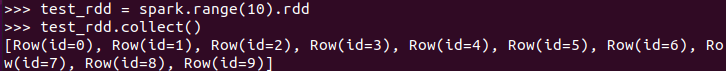

* 위 코드에선 Row타입 레코드를 그대로 RDD로 변환하였으므로 Row객체를 요소로 지니게 된다. 따라서 데이터 처리를 위해선 아래와 같은 변환이 필요하다.

In [ ]:
# Row 객체에서 값(row[0])만 추출하여 변환하여 숫자만을 요소로 지니는 RDD로 변환
test_rdd = spark.range(10).rdd.map(lambda row: row[0])
test_rdd.collect()

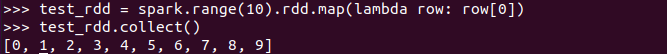

In [ ]:
# DataFrame으로 변환하여 데이터를 출력
test_df = spark.range(10).rdd.toDF()
test_df.show()

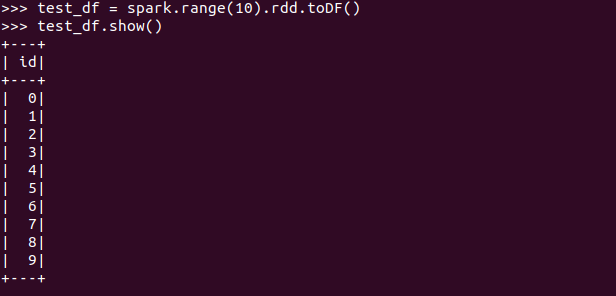

* toDF(): Row객체를 요소로 갖는 RDD의 경우 toDF()를 사용하여 DataFrame으로 변환 가능

* collect(): 데이터의 요소를 볼 수 있음
* show(): 데이터프레임의 형식을 볼 수 있음

### 지역성
* 사람이 aaa를 요청했을때, 캐시메모리에 aaa가 존재한다면 바로 사람에게 aaa반환
* 캐시메모리에 aaa가 없다면, 물리메모리에 aaa가 있는지 확인 후 있다면 캐시메모리로 전송 후 다시 사람에게 반환
* 물리메모리에도 aaa가 없다면, 디스크에 aaa가 존재하는지 확인 후 위의 과정이 반복될 것임
* 따라서 사람이 요구하는 것이 다르므로 캐시메모리, 물리메모리에 어떤 데이터를 저장해두는지가 관건 -> 지역성을 고려하여 메모리에 저장됨
* 파티션을 통해 물리메모리를 분할하여 더 빠르고 효율적으로 데이터를 처리 할 수 있음

### 캐시의 지역성
* 캐시가 효율적으로 동작하려면, 캐시의 적중률(Hit-rate)를 극대화 시켜야 함
* 캐시에 저장할 데이터가 지역성(Locality)을 가져야 한다.
* 지역성: 데이터 접근이 시간적, 혹은 공간적으로 가깝게 일어나는 것을 의미
* 전제조건으로 프로그램은 모든 코드나 데이터를 균등하게 Access하지 않는다는 특성을 기본으로 함
* 즉, 지역성이란 기억장치 내의 정보를 균일하게 Access하는 것이 아닌 어느 한 순간에 특정 부분을 집중적으로 참조하는 특성이다.

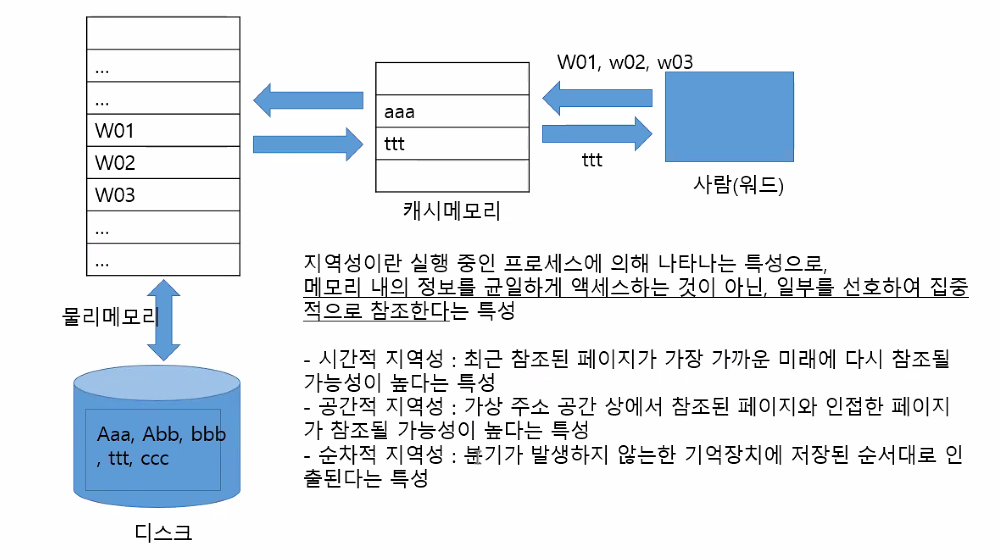

### Local collection으로 RDD 생성

In [ ]:
# 문장을 공백(' ')을 기준으로 분할하여 list화
myCollection = 'Spark The Definition Guid : Big Data Processing Made Simple'.split(' ')

words = spark.sparkContext.parallelize(myCollection, 2)

words.collect()

* Local collection: 어느 한 단일 노드에 있는 list, dictionary, set, array등을 의미
* spark.sparkContext.parallelize(local_collection, n): local collection 객체를 받아 n개의 파티션을 가지는 병렬 collection 객체 생성
* collect()<br>
    - RDD 또는 DataFrame 안의 요소들을 local collection객체(python에서는 list)로 가져옴
    - 병렬 collection을 단일 머신의 메모리에 불러와 local collection을 만드므로 큰 데이터셋에 대하여 collect()를 호출하는 경우 메모리 부족 문제를 일으킬 수 있음

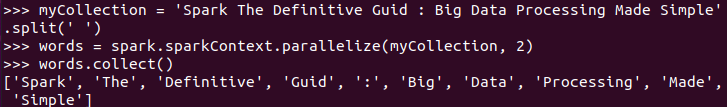

In [ ]:
# RDD 또는 데이터프레임의 첫번째 요소 반환
words.first()

# RDD 또는 데이터프레임에서 첫 n개의 요소 반환
words.take(3)

* first()<br>
    - RDD 또는 DataFrame에서 첫 번째 요소 반환
    - RDD의 데이터를 실제로 물리 메모리에 로드하므로 RDD가 제대로 로드 되었는지, 그리고 데이터가 어떻게 생겼는지 파악하는데 활용
    
* take(): RDD 또는 DataFrame에서 첫 n개의 요소 반환

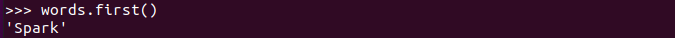

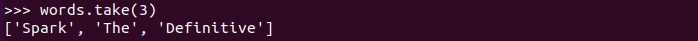

In [ ]:
# 파티션 개수 반환
words.getNumPartitions()

* getNumParitions(): RDD나 DataFrame의 파티션 개수 반환

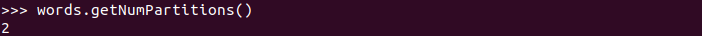

## 4. RDD 다루기

* RDD로 스행하는 연산은 트랜스포메이션(transformation)과 액션(action)으로 구성
* transformation은 데이터셋을 변경하거나 변환하는 연산이며, action은 실제로 계산이 수행되어 결과를 반환하거나 저장하는 연산
* Transformation: RDD를 다른 형태의 RDD로 변환(ex. filter-필터링, ㅡ메-qnstks, ...)
* Action: RDD에서 RDD가 아닌 다른 타입의 데이터로 변환(ex. count()-집계, collect()-집합, ...)

### Transformation
* 데이터의 불변성(Immutability)을 유지하기 위해 원본 데이터는 수정하지 않고, 연산 시 새로운 데이터 프레임을 생성(원본으로부터 변형(transformation))하여 결과를 반환<br>
-> Transformation 결과는 원본 RDD로부터 파생된 새로운 하나 또는 복수개의 RDD가 된다.

* 모든 Transformation은 지연 평가(Lazy evaluation)방식을 따름
* Lazy evaluation: 프로그래밍에서 표현식을 평가하는 전략 중 하나로, 표현식의 결과가 실제로 필요한 시점에만 평가하는 방식
    - 표현식(expression): 값을 생성하거나 변수, 상수, 연산자, 함수 등을 조합한 구문
    - 평가(evaluation): 해당 표현시의 결과값 계산
* Transformation결과는 즉시 계산되는 것이 아니라, Transformation이 선언되었다 라는것만 RDD lineage에 기록된다 <br>
-> Action이 호출되면 RDD lineage에 기록되어 있던 앞서 선언된 Transformation들이 모주 수행됨
* Spark는 실행 계획 후반에 RDD lineage를 참조하여 확실한 Transformation들끼리 재배열하거나 합쳐서 더 효율적으로 실행할 수 있도록 최적화 작업 수행
* Lazy evaluation은 action이 실행되어 결과가 반환되거나 데이터에 실제로 접근하는 시점(디스크에 I/O하는 시점)까지 실제 실행을 미루는 Spark의 전략
    - Spark가 사용자의 연계된 Transformation을 취합해 살펴봄으로써 쿼리 최적화 가능
    - 결과가 실제로 필요할 때까지 계산을 연기함으로써, 필요하지 않은 연산을 줄여 컴퓨팅 리소스를 절약
    <br> -> 이는 특히 큰 데이터셋에서 중요한 최적화 방법
    - 원본 데이터를 수정하지 않아 데이터 불변성을 유지하면서도 연산을 RDD lineage에 기록함으로써 장애 상황에 대한 데이터 내구성 확보

### 좁은/넓은 Transformation
* Transformation에는 2가지 유형이 존재
* Narrow: 변환 후 파티션이 하나의 파티션으로 매핑, 의존관계가 약함, NW미사용, 복원 가능(ex. map, filter, union, join with iputs co-partitioned)
* Wide: 변환 후 파티션이 여러 파티션으로 매핑, 의존관계가 강함, NW사용, 복원 시 비용 발생(ex. groupByKey, join with inputs not co-partitioned)

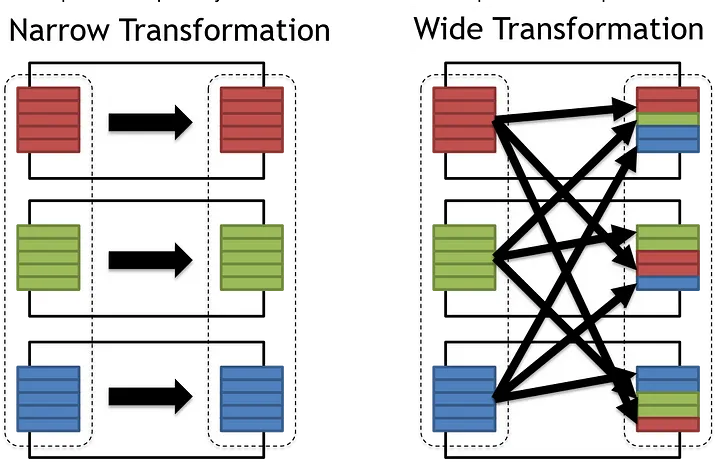

### 좁은 의존성(narrow dependency, narrow transformation)

* 하나의 입력 파티션을 연산하여 하나의 결과 파티션을 반환(1:1) -> 즉, 하나의 입력 파티션이 하나의 결과 파티션에만 영향을 미침
* 파티션 사이의 데이터 이동 없이 연산만 수행(파이프라이닝(Pipelining))하며 모든 작업이 메모리에서 수행됨
* filter(), map(), flatMap(), randomSplit() 등
* join with inputs co-partitioned: 두 개 이상의 데이터 파티션이 동일한 키, 동일한 방식으로 파티셔닝되어 있는 경우를 말함 -> 각 파티션들이 서로 독립적, 데이터 셔플(shuffle)없이도 조인 가능



### 넓은 의존성(wide dependency, wide transformation)
* 하나의 입력 파티션이 여러 출력 파티션에 영향을 미침(1:N)
* 파티션 간 데이터 이동인 셔플이 이뤄져야 하며, 이 때 Spark는 셔플 결과를 디스크에 저장
* distinct(), sortBy(), groupByKey(), reduceByKey(), join() 등

* 좁은 의존성과 넓은 의존성 예시

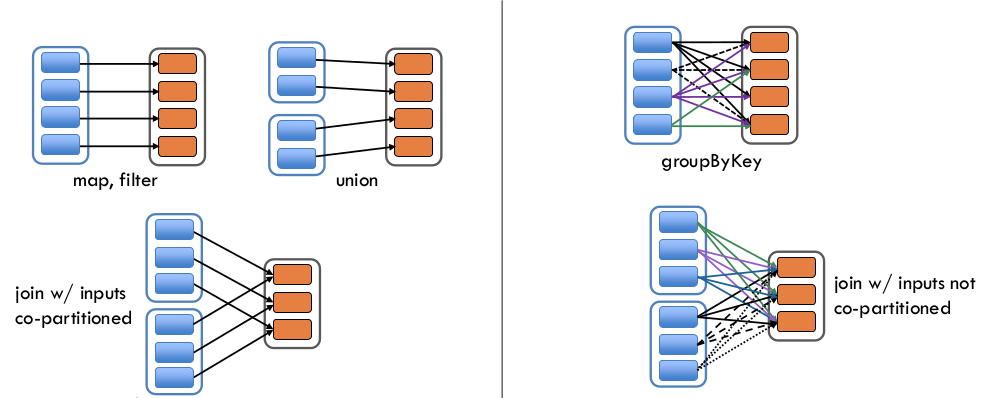

### Transformation 수행

In [ ]:
# 중복된 데이터 제거
words.collect()

words.distinct().collect()

* distinct(): RDD에서 중복된 데이터 제거

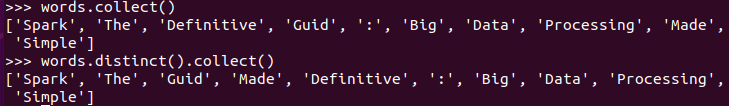

* 중복단어를 추가한 mycollection2를 생성하여 비교

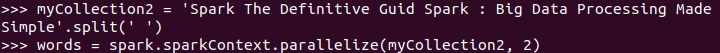

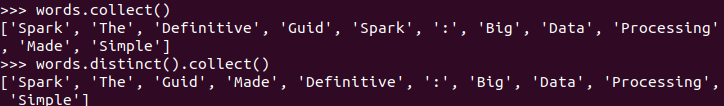

In [ ]:
# 조건에 맞는 레코드 반환
# 조건함수 정의
def startsWIthS(individual):
    return individual.startswith('S')

#  filter 함수 적용
words.filter(lambda word: startsWithS(word)).collect()

* filter()<br>
    - RDD의 레코드를 확인하고 조건 함수를 만족하는 레코드만 반환
    - filter()에 전달되는 요소는 조건함수에서 정의된 타입과 일치해야 한다.
    - 조건함수에서 쓰인 startswith()는 str타입에 대하여 주어진 인자로 시작하는지 여부를 검사해 boolean으로 반환<br> -> 조건함수에서 individual이 str로 정의되었으므로 RDD의 요소 word도 str이어야 한다.(만약 Row 객체인 경우 에러 발생)

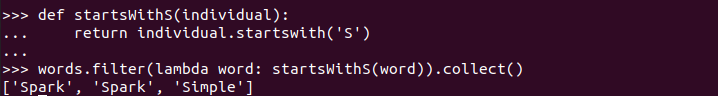

In [ ]:
# 여러 조건을 설정하여 출력
words2 = words.map(lambda word: (word, word[0], word.startswith('S')))
words.collect()

* map(): RDD안의 요소들을 원하는 값으로 변환

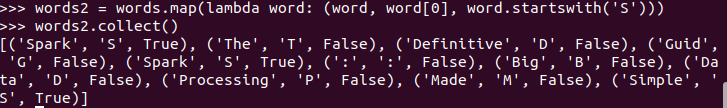

In [ ]:
# filter()를 적용하여 'S'로 시작하는 요소만 반환
words2.filter(lambda word: word[2]).take(5)

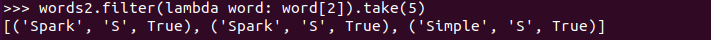

In [ ]:
# 여러개의 요소로 분fl
words.flatMap(lambda word: list(word)).take(10)

words.flatMap(lambda word: list(word)).take(8)

* flatMap()<br>
    - map()의 확장 버전, RDD의 각 요소를 여러 개의 요소로 분리
    - map()을 각 요소에 적용한 후 이를 잘게 쪼개서 결과를 평면화(flatten)
    * 예시에서는 단어를 문자의 집합으로 변환

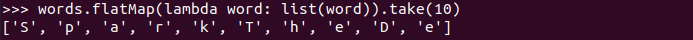

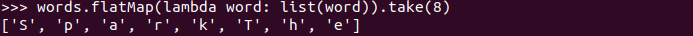

In [ ]:
# 요소들을 정렬
# 내림차순
words.sortBy(lambda word: len(word), ascending=False).collect()

# 오름차순
words.sortBy(lambda word: len(word)).collect()

* sortBy()<br>
    - 사용자 함수를 적용한 후 그 값을 기준으로 RDD내의 요소들 정렬
    - 기본적으로 오름차순(ascending ordering)이며 ascending옵션 제공(False = 내림차순)

* 내림차순

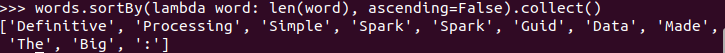

* 오름차순

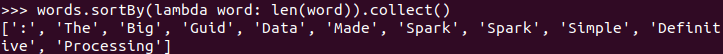

In [ ]:
# 임의의 난수를 부여하여 단어들을 분할
rs = words.randomSplit([0.5, 0.5])
rs[0].collect()
rs[1].collect()

* randomSplit()<br>
    - RDD를 임의로 분할해 RDD 배열을 만들 때 사용하며, 분할한 각 RDD에 대한 가중치로 구성된 배열과 난수 시드(seed=)를 인자로 받음
    - 가중치 배열은 양수로 이루어져야 하며 총합이 반드시 1이 되지 않아도 된다.<br>
    (ex. [2, 3]을 전달하면 첫 RDD에 40%, 두번째 RDD에 60%로 분할)
    - 하지만 가중치 배열이 반드시 지켜키는건 아니며 실제 결과는 이와 동일하지 않을 수 있다. seed가 고정되어있지 않다면 실행 시마다 결과값이 달라짐

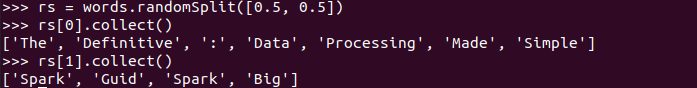

In [ ]:
# 임의의 난수를 변경하여 결과 확인
rs = words.randomSplit([0.25, 0.25, 0.25, 0.25])
rs[0].collect()
rs[1].collect()

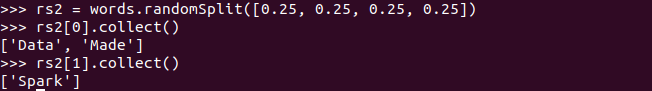

In [ ]:
# 그룹화
# 데이터 생성
data = [('apple', 3), ('banana', 2), ('apple', 1), ('banana', 2), ('apple', 3), ('orange', 4)]

rdd = spark.sparkContext.parallelize(data)
result = rdd.groupByKey()

for k, v in result.collect():
    print('{}: {}'.format(k, list(v)))

* groupByKey()<br>
    - 같은 key를 가진 value들을 그룹화
    - key-value 쌍을 가진 RDD에 사용되며, 결과로 (key, 동일한 키를 가진 모든 값들의 그룹)쌍을 요소로 갖는 RDD 생성

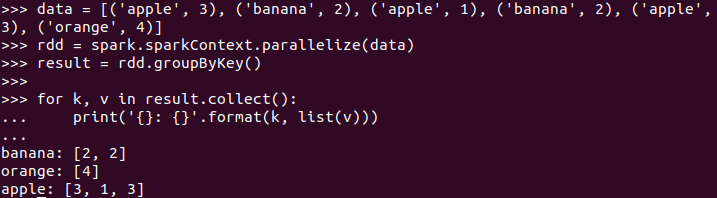

In [ ]:
# 같은 key를 가진 요소들에 대행 reduce함수 적용
result = rdd.reduceByKey(lambda a, b: a + b)

for k, v in result.collect():
    print('{}: {}'.format(k, v))

* reduceByKey()<br>
    - 같은 key를 가진 요소들에 대하여 reduce함수 적용
    - reduce함수: MapReduce의 그 reduce이다. 여러 데이터를 이항연산을 통해 처리하여 하나의 결과를 생성하는 연산<br> (예제에서는 reduce합수로 합(a+b)사용)
    - key-value 쌍을 가진 RDD에 사용되며, 결과로(key, reduce함수의 결과)쌍을 요소로 갖는 RDD생성

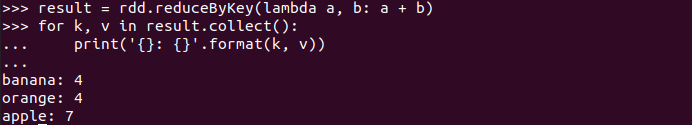

In [ ]:
# inner join
# 데이터 생성
rdd1 = sc.parallelize([("apple", 3), ("banana", 2), ("orange", 4)])
rdd2 = sc.parallelize([("apple", 8), ("banana", 7), ("grape", 6)])

joined_rdd = rdd1.join(rdd2)

for k, v in joined_rdd.collect():
    print(f"{k}: {v}")

* join()<br>
    - 두 개의 RDD를 대상으로 inner join 수행
    - key-value쌍을 가진 RDD에 사용되며, 결과로 (key, join결과)쌍을 요소로 갖는 RDD 생성
    - Spark에서는 이외에도 leftOuterJoin(), rightOuterJoin(), fullOuterJoin()와 같은 다양한 형태의 join연산 제공

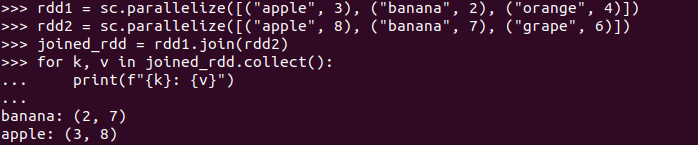

###  Action 수행
* 실제로 계산을 수행하여 결과를 반환<br>
-> RDD의 transformation은 action이 수행되어야 비로소 수행됨

In [ ]:
# pyspark 예시
# SparkSession객체인 spark로 transformation인 read()를 적용(실제 수행 X)하여
# spark 디렉토리의 README.md를 읽어와 DataFrame의 형태로 변수 Strings에 저장
# 이때, 각 행은 파일의 각 줄이며, value라는 column에 각 줄을 포함
strings = spark.read.text('./README.md')

# transformation인 filter(), contains()를 적용(실제 수행 X)하여
# 'Spark'라는 단어를 포함한 행만 선택
filtered = strings.filter(strings.value.contains('Spark'))

# action인 count()를 실행하여 필터링된 행의 갯수 산출
filtered.count()

# lineage에 기록된 transformation들 (read(), filter(), contains())은 여기서 실제로 실행됨

* 데이터를 driver에 모으거나 외부 데이터 소스로 내보낼 수 있다.
* collect(), first(), take(), reduce(), count(), countApprox(), countByValue(), max(), min(), aggregate(), fold(), treeReduce(), treeAggregate() 등

* Transformation과 Action의 구분

||Transformation|Action|
|---|---|---|
|수행 목적|데이터의 변환|데이터 처리 결과 산출|
|return|RDD|RDD가 아닌 데이터 type|


* 경로 오류가 날 경우 spark의 실행위차가 달라서 생기는 문제이다.
* exit()를 통해 spark를나간 후 README.md파일이 있는 위치에서 pyspark를 재실행하여 진행하거나, README.md을 현재 진행중인 spark경로에 복사-붙여넣기를 해준 뒤에 다시 진행하면 된다.

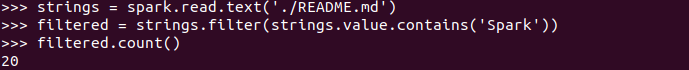

In [ ]:
# ex1: rdd내 모든 값 합계
spark.sparkContext.parallelize(range(1, 21)).reduce(lambda a, b: a + b)

# ex2: rdd내 가장 긴 단어 탐색
def wordLengthReducer(leftWord, rightWord):
    if len(leftWord) > len(rightWord):
        return leftWord
    else:
        return rightWord
    
words.reduce(wordLengthReducer)

* reduce(): RDD의모든 요소들에 reduce함수를 적용하여 하나의 값 반환

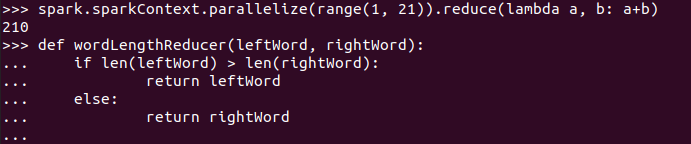

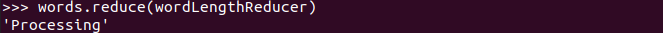

In [ ]:
# 단어의 개수 산출
words.count()

* count(): RDD내 요소들의 총 갯수 산출

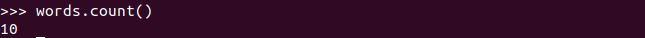

In [ ]:
# 시간 내에 계산을 수행하여 신뢰도 결과 반환
confidence = 0.95
timeoutMilliseconds = 400
words.countApprox(timeoutMilliseconds, confidence)

* countApprox(): timeout시간 내에 계산을 수행하여 주어진 confidence(신뢰도)의 count()결과 반환<br>
    - timeout: 함수가 반환될 때까지 대기하는 최대 시간(밀리초 단위)를 지정
    - confidence: 선택 사항, 결과의 정확도에 대한 신뢰도 지정, 0과 1사이의 값을 가지며, 기본값은 0.95 <br>
    (기본값일 경우 95%의 확률로 실제 카운트와 5% 이내의 오차를 가진 근사값을 반환하도록 설정)
    - 만약 timeout이 끝나면 주어진 confidence를 달성하지 못하더라도 현재까지의 값을 반환한다.
    - 대용량 데이터의 근사적인 count()를 빠르게 계산하고자 할 때 활용

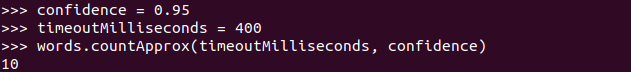

In [ ]:
# 요소의 등장 횟수 계산
words.countValue()

* countValue()<br>
    - RDD내의 각 요소가 몇 번 등장하는지 계산하여 (요소:횟수)형태의 map 반환
    - 모든 요소의 수를 카운트하므로 데이터가 큰 경우 메모리 문제 발생 가능

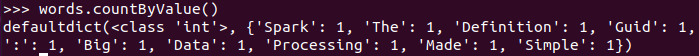

In [ ]:
# 최대값과 최소값 산출
# 최대값
spark.sparkContext.parallelize(range(1, 20)).max()

# 최소값
spark.sparkContext.parallelize(range(1, 20)).min()

* max(), min(): RDD내 요소들에 대하여 max()는 최대값, min()은 최소값 산출

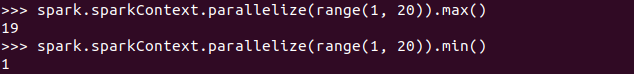

In [ ]:
# aggragate()를 사용한 총합 산출
# 예시 1: 총합 산출
# 데이터 생성
rdd = spark.sparkContext.parallelize(range(1, 8), 2)
rdd.collect()

# 시퀀스 함수 정의
seqOp = lambda acc, v: acc + v
# 콤바인 함수 정의
comOp = lambda acc1, acc2: acc1 + acc2

rdd.aggregate(0, seqOp, comOp)

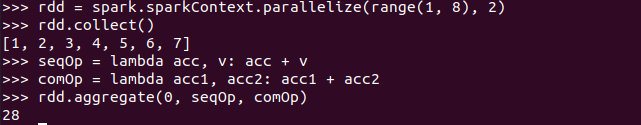

* aggregate()<br>
    - RDD내 요소들에 대하여 병렬로 분산 집계 연산을 수행
    - 사용을 위해 3개의 인자 필요
    - 제로 값(zero value): 집계 연산의 초기값, 각 파티션에 적용되며 집계연산에 영향을 미치지 않는 값
    - 시퀀스 함수(sqeOp): 같은 파티션 내 집계 연산을 수행하는 함수
    - 콤바인 함수(combOp): 서로 다른 파티션에서 계산된 결과를 결합하는 함수

In [ ]:
# 예시 2: 평균 산출
# 평균 산출을 위해선 총합과 총갯수가 필요하므로 집계값 형태를 (총합, 총 갯수)로 정의하여 초기값 설정
zero_value = (0, 0)

# 시퀀스 함수 정의
seqOp = lambda acc, v: (acc[0] + v, acc[1] + 1)
# acc = (총합, 총 갯수), v = 현재 값, acc[0] = 현재의 총합, acc[1] = 현재의 총 갯수

# 콤바인 함수 정의
combOp = lambda acc1, acc2: (acc1[0] + acc2[0], acc1[1] + acc2[1])
# acc1 = 파티션1의 (총합, 총 갯수), acc2 = 파티션2의 현재 총합
# acc1[0] 파티션1의 현재 총합, acc2[0] 파티션2의 현재 총합
# acc1[1] 파티션1의 현재 총 갯수, acc2[1] 파티션2의 현재 총 갯수

total, count = rdd.aggregate(zero_value, seqOp, combOp)
average = total/count
print(f"Total: {total}, Count: {count}, Average: {Average}")

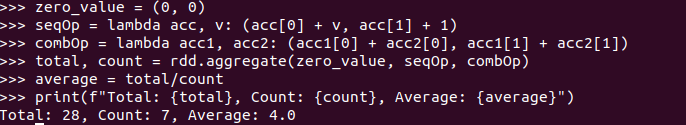

In [ ]:
# 적용 함수 정의
add = lambda acc, v: acc + v
rdd.fold(0, add)

* fold(): agreegate()와 유사하나 시퀀스 함수와 콤바인 함수가 나눠져 있어 파티션 내 연산, 타 파티션과의 연산을 다르게 설정할 수 있는 aggregate()와 달리 fold()는 모두 동일한 연산 적용

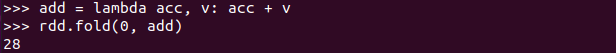

In [ ]:
# 네트워크의 병목현상을 줄여 계산을 빠르게 수행
rdd = spark.sparkContext.parallelize((range(1, 1000000)))
rdd.treeReduce(lambda a, b: a + b)

* treeReduce()<br>
    - reduce()와 기능적으로 유사하지만 데이터를 하나의 노드로 보내서 결합하는 기존의 방식과 달리 multi-level tree pattern을 적용하여 여러 단계, 여러 노드를 거치며 연산을 단계적/병렬적으로 처리
    - 네트워크 병목현상을 줄이고 대규모 데이터 세트에 대한 연산을 더욱 빠르게 수행

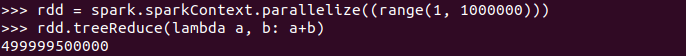

In [ ]:
zero_value = (0, 0)
seqOp = lambda acc, v: (acc[0] + v, acc[1] + 1)
combOp = lambda acc1, acc2: (acc1[0] + acc2[0], acc1[1] + acc2[1])
total, count = rdd.treeAggregate(zero_value, seqOp, combOp)
print(f"Total: {total}\nCount: {count}")

* treeAggregate(): treeReduce()처럼 aggregate()에 multi-level tree pattern적용

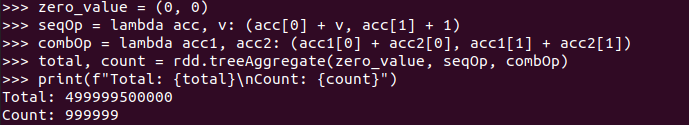

## 5. Key-Value RDD

* 앞서 봐왔던 Transformation과 Action들 처럼 이름이 <연산명>ByKey인 메소드가 존재(groupByKey(), reduceNyKey() 등)
* 이러한 메소드들은 key-value의 형태를 지니는 RDD만 사용할 수 있으며 이러한 형태의 RDD를 PairRDD라고 한다.

* PairRDD를 만드는 가장 쉬운 방법은 RDD에 map()연산을 수행해 key-value 구조로 만드는 것이다.

In [ ]:
# 단어를 소문자화한 후 key값으로 설정(value는 모두 1)
pairRDD1 = words.map(lambda word: (word.lower(), 1))
pairRDD1.collect()

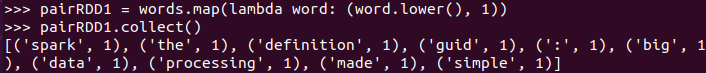

* key를 생성하는데 keyBy() 또한 사용 가능

In [ ]:
# 단어를 소문자화하여 첫글자를 key값으로 설정
pairRDD2 = words.map(lambda word: (word.lower(), 0))
pairRDD2.collect()

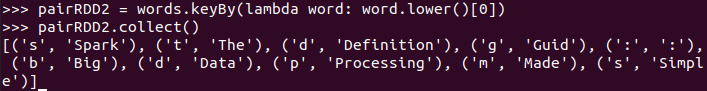

* mapValues()를 사용하여 각 key값에 value를 매핑 가능

In [ ]:
# 위에서 생성한 pairRDD2의 key들에 각 단어를 대문자화한 값을 value로 매핑
pairRDD3 = pairRDD2.mapValues(lambda word: (word.upper())
pairRDD3.collect()

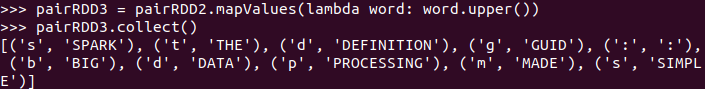

* 앞서 살펴본 flatMap()과 유사하게 pairRDD또한 flatMapValues()를 사용하여 value를 평면화하여 단어에서 문자로 확장 가능

In [ ]:
pairRDD4 = pairRDD2.flatMapValues(lambda word: word.upper())
pairRDD4.collect()

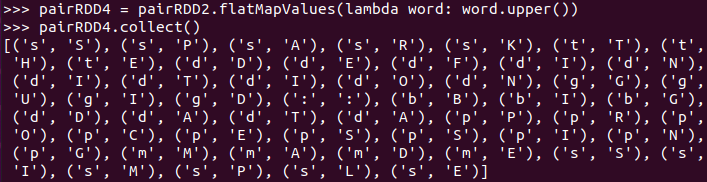

* keys(), values()를 사용하여 pairRDD에서 key값, value값들을 각각 추춣 가능함

In [ ]:
# key값 호출
pairRDD2.keys().collect()

# value값 추출
pairRDD2.values().collect()

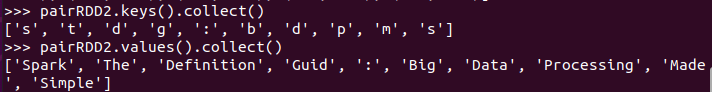

* lookup()을 사용하여 key값을 사용하여 value값 탐색 가능

In [ ]:
pairRDD2.lookup('s')

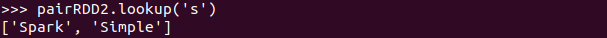

* 생성한 pairRDD를 기반으로 ByKey에 해당하는 연산들 이외에도 Join, Aggregate등 다양하고 강력한 연산들을 수행 가능

# 구조적 API/Spark SQL

## 1. 구조적(고수준) API

* Spark의 핵심 데이터 처리 인터페이스로 RDD가 지닌 단점을 개선하기 위하여 구조걱 형태를 도입
* 구조적 API는 크게 다음의 3가지로 구분(실습에서는 주로 DataFrame사용)

### DataFrame

* Row 객체 레코드와 컬럼을 가진 구조화된 분산 데이터 컬렉션에 대한 연산을 지원
* SQL의 테이블과 매우 유사하며, Spark SQL을 통해 SQL쿼리를 수행 가능
* 2.x버전 이전에는 DataFrame API와 DataSet API가 별도로 존재했지만, 2.x부터는 DataSet API에 통합됨(DataFrame=개별 Row의 타입이 지정되지 않은 DataSet)

### DataSet

* Spark의 타입형 API으로 타입 안정성을 제공: 컴파일 시 타입 검사로 잘못된 코드를 더 빨리 발견 가능
* 하지만 이는 변수를 선언할 때 타입이 명시되어야 하는 정적 언어(Java, Scala, ...)에서만 가능하며, 타입 명시가 필요하지 않은 동적 언어인 Python, R에서는 런타임 시 타입을 검사하기 때문에 사용 불가능
* 컴파일 타임: 프로그램이 컴파일러에 의해 기계어 또는 중간 코드(intermediate code)로 변환되는 시점
* 런타임: 프로그램이 실제로 실행되는 시점, 컴파일된 코드가 실제로 CPU에 의해 실행되며 필요한 계산을 수행

### SQL API

* Spark SQL릉 사용하여 SQL쿼리를 실행하는 데 사용
* DataFrame API와 완벽하게 호환
* SQL과 프로그래밍 언어를 사용한 데이터 처리를 혼합하고 교환하는데 사용 가능

## 구조적 API의 핵심 이점

### 높은 수준의 표현성

* 구조적 API는 SQL과 같은 높은 수준의 프로그래밍 인터페이스를 제공
* 사용자는 RDD에서처럼 복잡한 분산 처리 로직을 lambda식으로 일일히 명시적으로 작성할 필요 없이, 데이터 처리작업을 쉽게 정의 가능

### 스키마 추론 및 타입 안전성

* 구조적 API는 데이터의 스키마를 자동 추론하며, 이를 이용해 데이터의 타입 안정성 보장
* 코드의 신뢰성을 높히며, 런타임에 발생할 수 있는 타입 관련 오류를 줄인다.

### 최적화

* 구조적 API는 Spark SQL의 Catalyst 최적화 엔진 활용 -> Catalyst엔진은 사용자 정의 데이터 처리 작업을 최적화된 물리적 실행 계획으로 변환
* 이를 통해 더 빠른 실행 시간과 더 효율적인 자원 사용 가능

### 다양한 데이터 소스 지원

* 구조적 API는 다양한 데이터 소스(예: CSV, JSON, Parquet, JDBC, ORC, Kafka 등)를 지원
* 이를 통해 사용자는 다양한 형태의 데이터를 쉽게 읽고 쓸 수 있음

### 통합 API

* DataFrame과 Dataset API는 데이터의 구조화된 표현을 제공하며, 이를 통해 서로 다른 컴포넌트, 언어 간 일괄성을 갖고 주어진 연산을 처리 가능 -> SQL과 같은 쿼리와 프로그래밍 방식의 데이터 처리를 쉽게 결합 가능

## 구조적 API의 실행 과정

* 구조적 API 코드가 실제로 실행되는 과정은 다음과 같다.

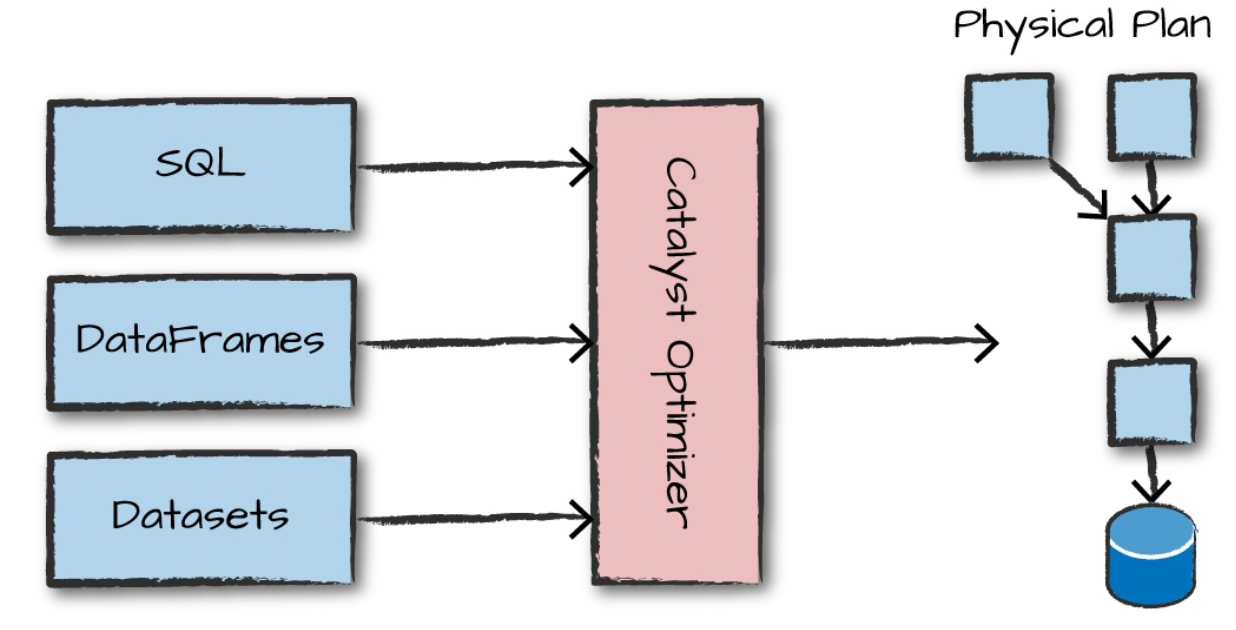

1. DataFrame/DataSet/SQL을 사용하여 코드 작성
2. [Catalyst Optimizer] 정상적인 코드라면 논리작 실행 계획(logical plan)으로 변환
3. [Catalyst Optimizer] 논리적 실행 계획을 물리적 실행 계획(pysical plan)으로 변환하며, 그 과정에서 추가적인 최적화를 할 수 있는지 확인
4. 클러스터레서 물리적 실행 계획(RDD 처리)을 실행

### 논리적 실행 계획
* 첫 번쨰 단계에선 사용자의 코드(user code)를 최적화된 논리적 실행 계획(optimizer logical plan)으로 변환
* 사용자의 다양한 표현식을 최적화된 버전으로 변환
* 이 단계에선 driver나 executor에 대한 정보는 고려하지 않으며, transformation의 추상적 표현만을 생성

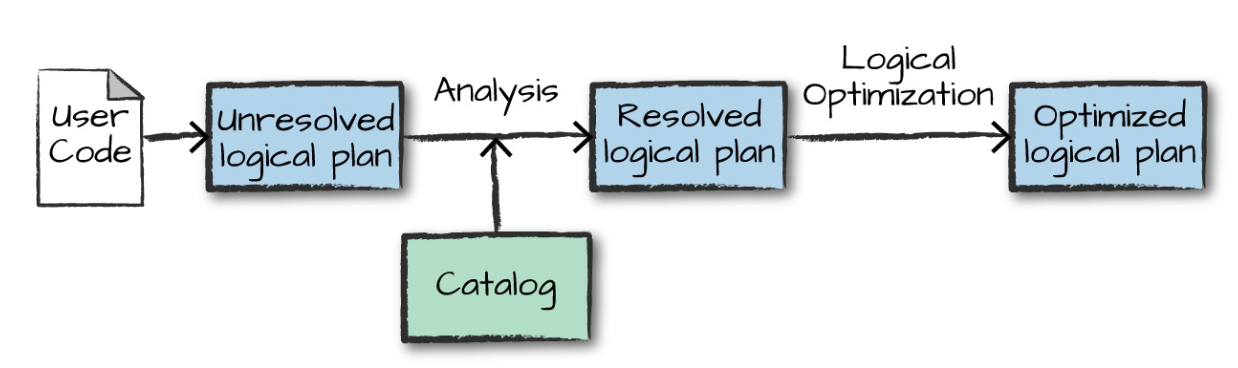

1. 사용자 코드를 검증 전 논리적 실행 계획(unresolved logical plan)으로 변환
2. Spark 분석기(analyzer)가 검증 전 논리적 실행 계획을 대상으로 코드의 유효성, 테이블 및 컬럼의 존재 여부를 검증하여 검증된 논리적 실행계획(resolved logical plan)으로 변환
    - SparkSession의 카탈로그에 존재하는 해당 session에서 접근 가능한 모든 테이블에 대한 정보를 바탕으로 테이블 및 컬럼 검증
    - 카탈로그: 사용자가 현재 SparkSession에서 사용가능한 모든 테이블, 뷰, 데이터베이스, 함수 등의 메타데이터 정보를 관리하는 컴포넌트
    - 해당 DataFrame의 transformation을 분석하여 DataFrame에 대한 정보 또한 검증에 활용
    - 필요한 테이블이나 컬럼이 카탈로그에 없다면 논리적 실행계획이 생성되지 않으며, 아직 실행 계획을 검증하지는 않음
3. 검증된 논리적 실행 계획을 최적화 과정을 거친 후 최적화된 논리적 실행 계획으로 변환

### 물리적 실행 계획
* 최적화된 논리적 실행 계획을 클러스터 환경에서 실행하는 방법을 정의
* driver, executor등 물리적 요인들에 대한 정보는 이 단계에서 고려

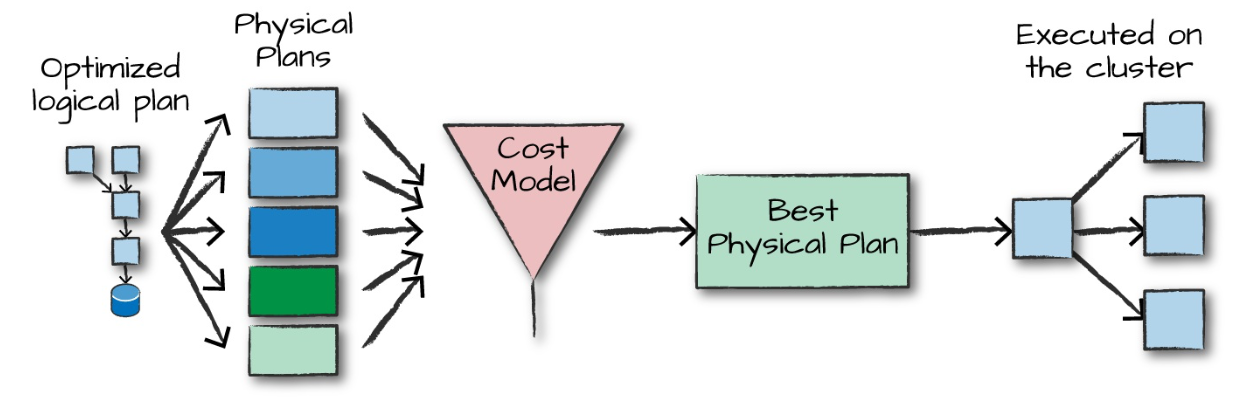

1. 최적화된 논리적 실행 계획으로부터 다양한 물리적 실행 계획을 생성
2. 비용 모델(cost model)을 이용해서 물리적 실행 계획들을 비교한 후 최적의 물리적 실행 계획(best physical plan)을 선택<br>
    - 테이블 크기, 파티션 수, CPU, 네트워크 등 물리적 속성을 고려하여 연산 수행에 필요한 비용을 계산하고 비교
3. 최적의 물리적 실행 계획을 바탕으로 각 노드에서 실행할 효율적인 RDD transformation으로 변환(RDD transformation으로 컴파일링)
    - Catalyst Optimizer는 지금까지의 일련의 과정인 논리적 계획 생성 -> 논리적 계획 최적화 -> 물리적 계획 생성 -> 물리적 계획 최적화 -> 코드 생성을 수행
    
4. cluster에서 executor들에 할당되어 실행한 후 결과값 반환

## 2. DataFrame

* Python 라이브러리 Pandas의 데이터프레임에 영향을 받음
* 컬럼과 스키마를 가진 분산 인메모리 테이블 처럼 동작
* DataFrame도 RDD와 마찬가지로 데이터 불변성을 지니며 모든 변경 내역을 lineage에 보관

### Spark의 기본 데이터 타입
* Spark는 지원하는 프로그래밍 언어에 맞게 기본적인 내부 데이터 타입 지원
* Python에서는 스키마를 통해 데이터타입 정의 가능
* 이는 Python의 변수 타입 선언이 아닌, Spark의 데이터 처리 구조 정의(혼동 주의)<br>
(Python은 동적 언어, 변수 값 할당 시 타입이 결정되므로 타입 선언 불필요)

* Spark의 기본 Python 데이터 타입
|Spark 데이터 타입|Python 데이터 타입|초기 생성 API|
|---|---|---|
|ByteType|int|DataTypes.ByteType|
|ShortType|int|DataTypes.ShortType|
|IntegerType|int|DataTypes.IntegerType|
|LongType|int|DataTypes.LongType|
|FloatType|int|DataTypes.FloatType|
|DoubleType|int|DataTypes.DoubleType|
|StringType|int|DataTypes.StringType|
|BooleanType|int|DataTypes.BooleanType|
|DecimalType|int|DataTypes.DecimalType|

### Spark의 정형화 타입과 복합 타입
* Spark는 복합적인 데이터 분석에 사용할 수 있도록 별도의 자체적 구조를 지니고 있거나, 내부적으로 반복되는 데이터에 대한 타입도 취급 가능
* Spark의 Python 정형화/복합 데이터 타입

|Spark 데이터 타입|Python 데이터 타입|초기 생성 API|
|---|---|---|
|BinaryType|bytearray|BinaryType()|
|TimestampType|datatime.datetime|TimestampType()|
|DataType|datatime.date|DataType()|
|ArrayType|list, tuple, array, ...|ArrayType(datatype, [nullable])|
|MapType|dict|MapType(keyType, valueType, [nullable])|
|StructType|구조체 타입(list, tuple, ...)|StructType([fields])|
|StructField|해당 필드와 맞는 값의 타입|StructField(name, dataType, [nullable])|

## 스키마, 컬럼, 로우

### 스키마(Schema)
* Spark에서 스키마는 DataFrame을 위해 컬럼 이름과 연관된 데이터 타입을 정의한 것
* 외부 데이터 소스에서 구조화된 데이터를 읽어 들일 때 많이 사용
* 데이터를 가져오면서 스키마를 자동으로 읽어올 수도 있음<br>
<-> 하지만 미리 스키마를 정의할 시 다음 3가지 이점이 존재, 데이터가 클수록 미리 정의를 권장
1. Spark가 데이터 타입을 추축해야 하는 책임을 덜어준다.
2. Spark가 스키마를 확정을 위하여 파일의 많은 부분을 읽어 들이고자 별도의 Job을 만드는 것을 방지<br>
-> 데이터 파일이 큰 경우, 이는 많은 시간과 비용 소요
3. 데이터가 스키마와 맞지 않는 경우 조기에 문제 발견 가능

### 스키마를 정의하는 2가지 방법
1. 프로그래밍 스타일로 정의

In [ ]:
from pyspark.sql.types import *
schema = StructType([StructField("author", StringType(), False),
                    StructField("title", StringType(), False),
                    StructField("pages",IntegerType(), False)])

print(schema)

* StructType(): StructField()를 포함하는 구조체 타입
* StructField(): DataFrame의 각 컬럼(필드)를 나타냄
    - 첫 번째 인자: 컬럼명
    - 두 번째 인자: 컬럼의 데이터 타입
    - 세 번째 인자: null값 허용(nullable) 여부

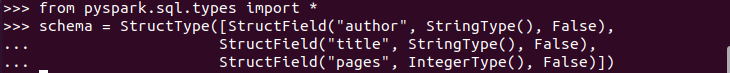

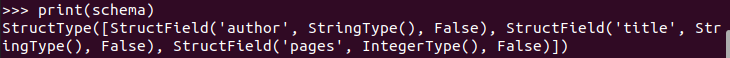

2. SQL의 DDL(Data Definition Language) 사용

In [ ]:
schema = "author STRING, title STRING, pages INT"
print(schema)

* DDL을 사용한 예시
    - DDL은 컬럼의 nullable 여부를 설정할 수 없으므로, 설정이 필요하다면 프로그래밍 스타일 방식 사용
    - show(): DataFrame출력
    - printSchema(): DataFrame에서 사용된 스키마 출력
    * 출력만 있고 반환되는 객체가 없으므로 print(printSchema())의 형태로 사용 시, 최하단에 None메시지가 반환되므로 주의할 것

In [ ]:
# DDL을 사용하여 스키마 정의
schema = "Id INT, First STRING, Last STRING, Url STRING,\
            Published STRING, Hits INT, Campaigns ARRAY<STRING>"

# 데이터 생성, collection 형태로 정의
data = [[1, "Jules", "Damji", "http://tinyurl.1", "1/4/2016", 4535, ["twitter", "LinkedIn"]],
       [2, "Brooke", "Wenig", "http://tinyurl.2", "5/5/2018", 8908, ["twitter", "LinkedIn"]],
       [3, "Denny", "Lee", "http://tinyurl.3", "6/7/2019", 7659, ["web", "twitter", "FB", "LinkedIn"]],
       [4, "Tathagata", "Das", "http://tinyurl.4", "5/12/2018", 10568, ["twitter", "FB"]],
       [5, "Matei", "Zaharia", "http://tinyurl.5", "5/14/2014", 40578, ["web", "twitter", "FB", "LinkedIn"]],
       [6, "Reynold", "Xin", "http://tinyurl.6", "3/2/2016", 25568, ["twitter", "LinkedIn"]]]

# 위에서 정의한 스키마로 DataFrame 생성
blog_df = spark.createDataFrame(data, schema)

# DataFrame출력
blog_df.show()

# 스키마 출력
blog_df.printSchema()

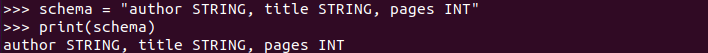

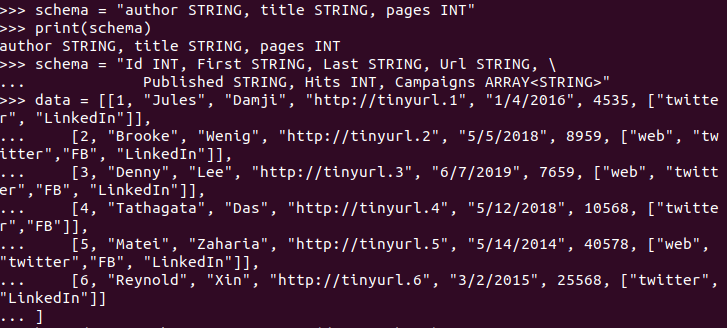

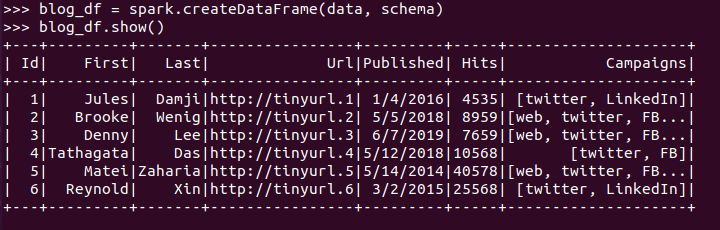

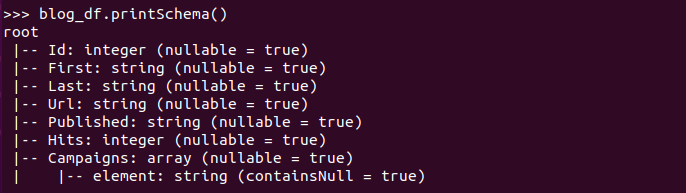

### 컬럼(column)과 표현식
* DataFrame테이블의 컬럼으로 pandas 데이터프레임의 컬럼과 유사
* 컬럼 내용을 수정하려면 반드시 transformation 사용 필요
* pandas는 데이터를 메모리에 모두 불러오므로 df["col_name"]과 같은 인덱싱 가능<br>
-> Spark는 빅데이터 처리를 위하여 설계되었으므로, 일반적으로 데이터가 단일머신 메모리를 초과할 것으로 가정 & 클러스터 정체에서 효율적으로 처리하는 방향으로 연산 
* df["col_name"]와 같은 형태는 해당 컬럼에 대한 참조만 가능하며, 열 데이터를 즉시 반환하지 않음.
* df.select("col_name").show() transformation과 action의 조합으로 연산

In [ ]:
from pyspark.sql.functions import col, column
blog_df.select(col("Id")).show()
blog_df.select(column("Id")).show()
blog_df.select("Id").show()

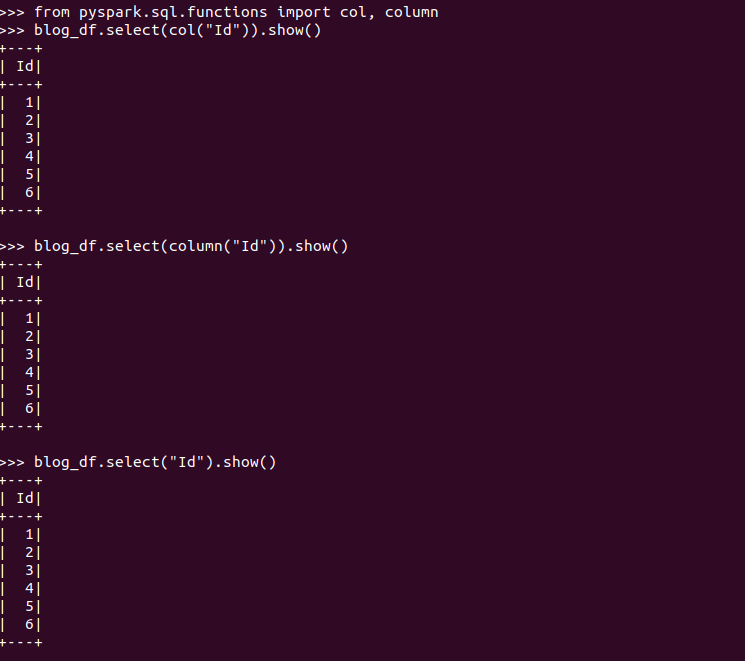

In [ ]:
# 복수의 컬럼 선택
blog_df.select("Id", "First", "Last").show()

* col(), column(): 컬럼 참조를 위한 메소드
    - 둘은 동일하며 가독성 및 사용이 용이한 col()을 더 많이 사용
* select(): SQL의 'SELECT'와 유사하게 기능하며, DataFrame에서 특정 컬럼 선택 사용
    - transformation이며, action인 show()가 호출되었을때 연산
* Spark에서의 컬럼은 레코드(Row)단위로 계산한 값을 표현식을 사용해 단순하게 나타낸 논리적 구조 -> 컬럼은 표현식으로 표현 가능<br>
(표현식: 레코드에 존재하는 여러 값들을 산출하기 위한 transformation들의 집합을 문자열로 표현한 것)

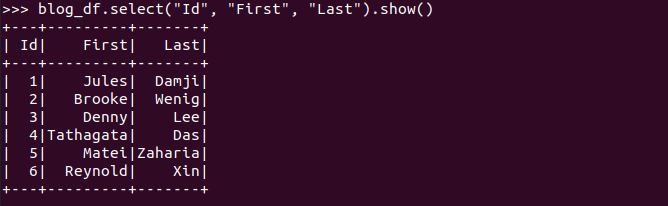

In [ ]:
from pyspark.sql.functions import expr

blog_df.select(expr("Id")).show()

* expr(): 표현식 사용을 위한 메소드
    - col(), column()과 똑같은 결과 반환

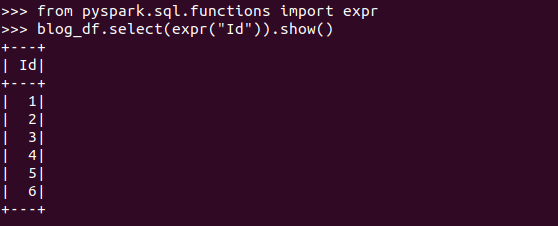

In [ ]:
# 모두 같은 결과 출력
blog_df.select(expr("Hits * 2")).show(3)
blog_df.select(expr("Hits") * 2).show(3)
blog_df.select(col("Hits") * 2).show(3)

* 컬럼명 대신 연산식을 넣은 expr("Hits * 2")도 나머지 둘과 같은 결과 반환
* 단, 표현식 expr()이 아닌, col()에 연산식을 넣은 col("Hits * 2")는 에러 발생

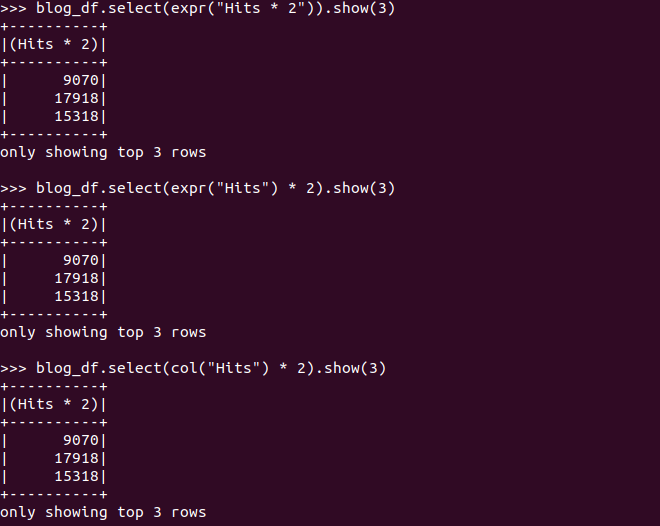

### 레코드와 로우(Row)
* 각 데이터 레코드를 의미, DataFrame테이블의 각 행(레코드)은 Row타입 객체로 구성됨
* Row 객체는 내부에 바이트 배열을 가진다.<br>
-> 이 바이트 배열은 컬럼 표현식으로 표현 가능하며, 사용자에게 노출되지 않음

In [ ]:
spark.range(2).show()

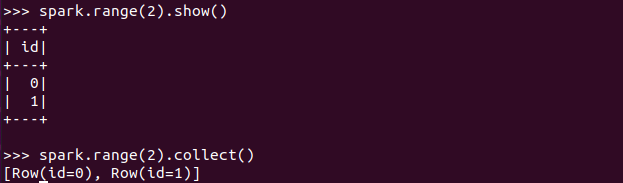

In [ ]:
# Row 생성 및 접근
from pyspark.sql import Row

myRow = Row("Hello", None, 1, False)

* Row(): Row 객체 생성

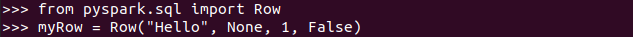

In [ ]:
myRow[0]
myRow[3]

* Row내 데이터의 접근은 간편하게 인덱싱으로 가능
* 스키마는 DataFrame만 가질 수 있으며, Row객체에는 스키마 정보가 없음
* Scala와 java의 경우 접근을 위해 데이터 타입을 지정해야 하는 과정이 필요하나, Python은 해당하는 데이터 타입으로 자동 변환되므로 바로 확인 가능

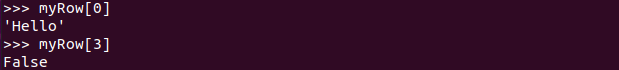